In [186]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [187]:
import numpy as np

import random
import warnings
import thinkstats2
import thinkplot
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
## Excercise 9.1

In [ ]:
##### **Question :**

As sample size increases, the power of a hypothesis test increases, which means it is more likely to be positive if the effect is real. Conversely, as sample size decreases, the test is less likely to be positive even if the effect is real. 
To investigate this behavior, run the tests in this chapter with different subsets of the NSFG data. You can use thinkstats2.SampleRows to select a random subset of the rows in a DataFrae


What happens to the p-values of these tests as sample size decreases? What is the smallest sample size that yields a positive test?

In [190]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/first.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz"
)


#### To investigate how the p-values of hypothesis tests change as the sample size decreases, a solution using the NSFG (National Survey of Family Growth) dataset  needs to be implemented. 

#### Following tests needs to be run as the sample size decreases:

#### Difference in mean pregnancy length between first-born and non-first-born children.

#### Difference in mean birth weight between first-born and non-first-born children.

#### Correlation between the mother's age and birth weight.

#### Chi-squared test on pregnancy lengths.
    
#### The goal is to observe how the p-values from these tests change as the sample size reduces and identify the smallest sample size that yields a significant (positive) test.

In [192]:
import first

live, firsts, others = first.MakeFrames()
data = firsts.prglngth.values, others.prglngth.values

In [193]:
class DiffMeansPermute(thinkstats2.HypothesisTest):
    # Compute the test statistic: absolute difference in means between two groups
    def TestStatistic(self, data):
        sample1, sample2 = data  # Unpack the two samples
        diff_means = abs(sample1.mean() - sample2.mean())  # Compute absolute mean difference
        return diff_means

    # Prepare the model by combining both groups into one pool for permutation
    def MakeModel(self):
        sample1, sample2 = self.data  # Unpack the two samples from data
        self.size_sample1, self.size_sample2 = len(sample1), len(sample2)  # Store the size of each sample
        self.combined_pool = np.hstack((sample1, sample2))  # Combine both samples into a single array

    # Run the permutation model by shuffling the combined pool and splitting it into new groups
    def RunModel(self):
        np.random.shuffle(self.combined_pool)  # Shuffle the combined pool
        shuffled_data = self.combined_pool[:self.size_sample1], self.combined_pool[self.size_sample1:]  # Split shuffled pool
        return shuffled_data


In [194]:
class CorrelationPermute(thinkstats2.HypothesisTest):
    # Compute the test statistic: absolute value of the correlation between two variables
    def TestStatistic(self, data):
        var_x, var_y = data  # Unpack the two variables
        correlation_stat = abs(thinkstats2.Corr(var_x, var_y))  # Compute absolute correlation
        return correlation_stat

    # Run the permutation model by shuffling one variable and keeping the other constant
    def RunModel(self):
        var_x, var_y = self.data  # Unpack the original variables
        var_x_shuffled = np.random.permutation(var_x)  # Shuffle the values of var_x
        return var_x_shuffled, var_y  # Return the shuffled var_x and original var_y


In [195]:
class PregLengthTest(thinkstats2.HypothesisTest):
    # Prepare the model by combining the data for first and subsequent pregnancies into a pool
    def MakeModel(self):
        first_pregnancies, other_pregnancies = self.data  # Unpack the data
        self.num_first_pregnancies = len(first_pregnancies)  # Store the number of first pregnancies
        self.combined_pool = np.hstack((first_pregnancies, other_pregnancies))  # Combine both groups into a single array

        # Create a PMF (probability mass function) from the combined pool
        pmf = thinkstats2.Pmf(self.combined_pool)
        self.length_values = range(35, 44)  # Define the range of pregnancy lengths (weeks)
        self.expected_probs = np.array(pmf.Probs(self.length_values))  # Calculate expected probabilities for each length

    # Run the permutation model by shuffling the pool and splitting it into two new groups
    def RunModel(self):
        np.random.shuffle(self.combined_pool)  # Shuffle the combined pool
        shuffled_data = self.combined_pool[:self.num_first_pregnancies], self.combined_pool[self.num_first_pregnancies:]  # Split into two groups
        return shuffled_data

    # Compute the test statistic: sum of Chi-squared values for the two groups
    def TestStatistic(self, data):
        first_pregnancies, other_pregnancies = data  # Unpack the shuffled groups
        chi_square_stat = self.ChiSquared(first_pregnancies) + self.ChiSquared(other_pregnancies)  # Sum of Chi-squared stats
        return chi_square_stat

    # Compute the Chi-squared statistic for a given set of pregnancy lengths
    def ChiSquared(self, lengths):
        histogram = thinkstats2.Hist(lengths)  # Create a histogram of pregnancy lengths
        observed_freqs = np.array(histogram.Freqs(self.length_values))  # Get observed frequencies for the defined lengths
        expected_freqs = self.expected_probs * len(lengths)  # Compute expected frequencies based on probabilities
        chi_square_stat = sum((observed_freqs - expected_freqs)**2 / expected_freqs)  # Calculate Chi-squared statistic
        return chi_square_stat


In [196]:
import thinkstats2
import numpy as np
import pandas as pd

def run_statistical_tests(live_data, iterations=1000):
    """
    Run hypothesis tests on a subset of live birth data.
    
    Parameters:
    live_data: DataFrame containing the live birth data sample.
    iterations: Number of iterations for permutation tests.
    
    Prints:
    - Sample size and p-values for each test.
    """
    sample_size = len(live_data)
    
    # Divide data into first-born and non-first-born children
    first_born = live_data[live_data.birthord == 1]
    non_first_born = live_data[live_data.birthord != 1]
    
    # Test 1: Difference in mean pregnancy length (first-born vs others)
    preg_length_data = first_born.prglngth.values, non_first_born.prglngth.values
    test_preg_length = DiffMeansPermute(preg_length_data)
    p_value_preg_length = test_preg_length.PValue(iterations)
    
    # Test 2: Difference in mean birth weight (first-born vs others)
    birth_weight_data = first_born.totalwgt_lb.dropna().values, non_first_born.totalwgt_lb.dropna().values
    test_birth_weight = DiffMeansPermute(birth_weight_data)
    p_value_birth_weight = test_birth_weight.PValue(iterations)
    
    # Test 3: Correlation between mother's age and birth weight
    live_cleaned = live_data.dropna(subset=['agepreg', 'totalwgt_lb'])
    age_weight_data = live_cleaned.agepreg.values, live_cleaned.totalwgt_lb.values
    test_correlation = CorrelationPermute(age_weight_data)
    p_value_correlation = test_correlation.PValue(iterations)
    
    # Test 4: Chi-squared test on pregnancy lengths
    test_chi2 = PregLengthTest(preg_length_data)
    p_value_chi2 = test_chi2.PValue(iterations)
    
    # Print sample size and corresponding p-values
    print(f"Sample Size: {sample_size}\t"
          f"Preg Length P-Value: {p_value_preg_length:.2f}\t"
          f"Birth Weight P-Value: {p_value_birth_weight:.2f}\t"
          f"Age-Birth Weight Correlation P-Value: {p_value_correlation:.2f}\t"
          f"Chi-Squared P-Value: {p_value_chi2:.2f}")

def analyze_sample_size_impact(live_data, iterations=1000):
    """
    Analyzes the impact of sample size on hypothesis test results by progressively 
    reducing the sample size and running statistical tests.
    
    Parameters:
    live_data: DataFrame containing live birth data from the NSFG dataset.
    iterations: Number of iterations for permutation tests.
    
    Prints:
    - P-values for various statistical tests at different sample sizes.
    """
    sample_size = len(live_data)
    
    # Loop to halve the sample size at each iteration
    while sample_size >= 50:  # Stop when the sample size is smaller than 50
        # Get a random subset of the data
        sample = thinkstats2.SampleRows(live_data, sample_size)
        
        # Run the tests on the current sample
        run_statistical_tests(sample, iterations)
        
        # Halve the sample size for the next iteration
        sample_size //= 2



In [197]:
analyze_sample_size_impact(live)

Sample Size: 9148	Preg Length P-Value: 0.16	Birth Weight P-Value: 0.00	Age-Birth Weight Correlation P-Value: 0.00	Chi-Squared P-Value: 0.00
Sample Size: 4574	Preg Length P-Value: 0.66	Birth Weight P-Value: 0.00	Age-Birth Weight Correlation P-Value: 0.00	Chi-Squared P-Value: 0.00
Sample Size: 2287	Preg Length P-Value: 0.15	Birth Weight P-Value: 0.55	Age-Birth Weight Correlation P-Value: 0.00	Chi-Squared P-Value: 0.00
Sample Size: 1143	Preg Length P-Value: 0.81	Birth Weight P-Value: 0.10	Age-Birth Weight Correlation P-Value: 0.01	Chi-Squared P-Value: 0.11
Sample Size: 571	Preg Length P-Value: 0.29	Birth Weight P-Value: 0.22	Age-Birth Weight Correlation P-Value: 0.22	Chi-Squared P-Value: 0.00
Sample Size: 285	Preg Length P-Value: 0.69	Birth Weight P-Value: 0.62	Age-Birth Weight Correlation P-Value: 0.63	Chi-Squared P-Value: 0.78
Sample Size: 142	Preg Length P-Value: 0.53	Birth Weight P-Value: 0.03	Age-Birth Weight Correlation P-Value: 0.29	Chi-Squared P-Value: 0.41
Sample Size: 71	Preg Le

### Observations:

- #### As the sample size decreases, the p-values tend to increase, making the tests less likely to show statistical significance. This is expected because smaller samples have less statistical power.
- #### Some tests still yield significant results with small sample sizes, depending on the effect size and the nature of the data.




### Conclusion:

#### As sample size decreases, the p-values increase, reflecting the reduction in statistical power. The smallest sample size yielding a significant test depends on the effect size and test type. Statistical tests with small sample sizes are more prone to yielding non-significant results even when an effect is present.

## Excercise 10.1

#### **Exercise:** Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height. How would you best present the estimated parameters for a model like this where one of the variables is log-transformed? If you were trying to guess someone’s weight, how much would it help to know their height?

#### Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent. In the BRFSS data, the variable name for these weights is totalwt. Use resampling, with and without weights, to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval. How much does correct weighting affect the estimates?

In [204]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/brfss.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/CDBRFS08.ASC.gz")

In [205]:

# Import necessary libraries and custom brfss module
import brfss
import thinkstats2
import thinkplot
import numpy as np
import pandas as pd
import brfss



#### Load the dataset and clean missing data

In [207]:
# Load the BRFSS data into a DataFrame
df = brfss.ReadBrfss(nrows=None)

# Drop rows where height or weight data is missing
df = df.dropna(subset=['htm3', 'wtkg2'])

# Extract height (in cm) and weight (in kg)
heights = df['htm3']
weights = df['wtkg2']

# Log-transform the weight to make the relationship linear
log_weights = np.log10(weights)


#### Compute the linear least squares regression for height and log-weight

In [209]:
# Perform linear least squares regression to find intercept and slope
intercept, slope = thinkstats2.LeastSquares(heights, log_weights)
print("Intercept:", intercept)
print("Slope:", slope)


Intercept: 0.9930804163932845
Slope: 0.005281454169417795


#### Plot log(weight) versus height with the regression line

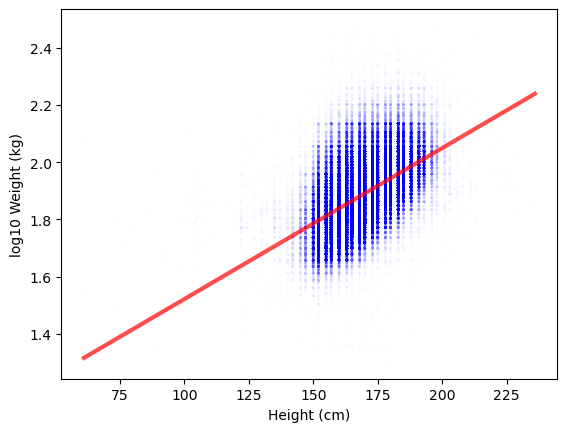

In [211]:
# Plot scatter plot of height vs. log10(weight)
thinkplot.Scatter(heights, log_weights, alpha=0.01, s=5)

# Fit a regression line based on the computed slope and intercept
x_fit, y_fit = thinkstats2.FitLine(heights, intercept, slope)

# Plot the fitted line on top of the scatter plot
thinkplot.Plot(x_fit, y_fit, color='red')
thinkplot.Config(xlabel='Height (cm)', ylabel='log10 Weight (kg)', legend=False)


#### Plot weight versus height with regression line (back-transformed from log)

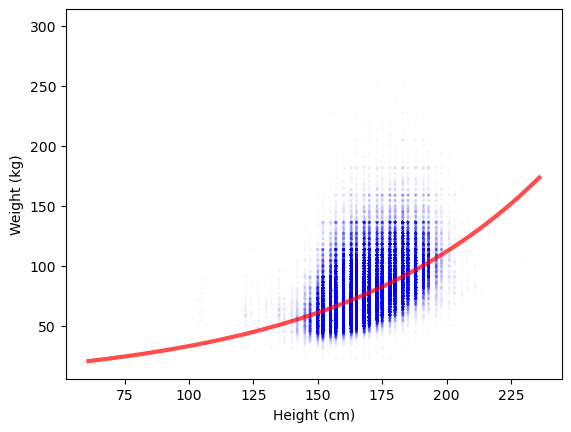

In [213]:
# Scatter plot of height vs. weight
thinkplot.Scatter(heights, weights, alpha=0.01, s=5)

# Plot the regression line transformed back from log-scale
thinkplot.Plot(x_fit, 10**y_fit, color='red')
thinkplot.Config(xlabel='Height (cm)', ylabel='Weight (kg)', legend=False)


#### Analyze residuals

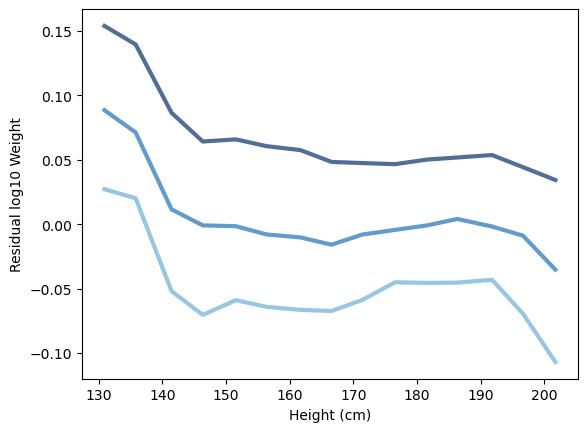

In [215]:
# Compute residuals between the observed log10(weight) and predicted log10(weight)
residuals = thinkstats2.Residuals(heights, log_weights, intercept, slope)
df['residual'] = residuals

# Bin heights into intervals for analysis of residuals
height_bins = np.arange(130, 210, 5)
indices = np.digitize(df['htm3'], height_bins)

# Group data by binned height intervals
groups = df.groupby(indices)

# Calculate mean heights and cumulative distribution functions (CDFs) for each group
mean_heights = [group['htm3'].mean() for i, group in groups][1:-1]
cdfs = [thinkstats2.Cdf(group['residual']) for i, group in groups][1:-1]

# Plot 25th, 50th, and 75th percentiles of residuals across height bins
thinkplot.PrePlot(3)
for percentile in [75, 50, 25]:
    y_values = [cdf.Percentile(percentile) for cdf in cdfs]
    label = f'{percentile}th Percentile'
    thinkplot.Plot(mean_heights, y_values, label=label)

thinkplot.Config(xlabel='Height (cm)', ylabel='Residual log10 Weight', legend=False)


#### Calculate the correlation and R-squared values

In [217]:
# Compute the correlation between height and log10(weight)
correlation = thinkstats2.Corr(heights, log_weights)
print("Correlation:", correlation)

# Compute the coefficient of determination (R-squared) based on the residuals
r_squared = thinkstats2.CoefDetermination(log_weights, residuals)
print("R-squared:", r_squared)

# Check if the square of the correlation is close to R-squared
print(np.isclose(correlation**2, r_squared))


Correlation: 0.5317282605983439
R-squared: 0.2827349431189392
True


#### Standard deviation analysis

In [219]:
# Compute standard deviation of log10(weight)
std_log_weights = thinkstats2.Std(log_weights)
print("Standard Deviation of log10 Weight:", std_log_weights)

# Compute standard deviation of the residuals
std_residuals = thinkstats2.Std(residuals)
print("Standard Deviation of Residuals:", std_residuals)

# Fraction of variance explained by the regression model
variance_explained = 1 - std_residuals / std_log_weights
print("Fraction of variance explained:", variance_explained)


Standard Deviation of log10 Weight: 0.10320725030004888
Standard Deviation of Residuals: 0.08740777080416089
Fraction of variance explained: 0.15308497658793363


#### Resampling for regression estimates

{'xscale': 'linear', 'yscale': 'linear'}

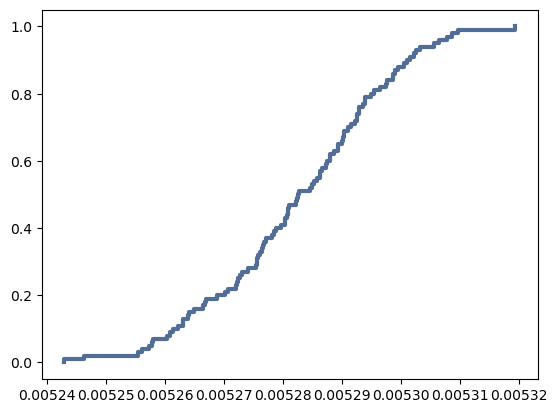

In [221]:
# Resample rows and perform least squares regression to estimate intercept and slope
t = []
for _ in range(100):
    sample = thinkstats2.ResampleRows(df)
    estimates = thinkstats2.LeastSquares(sample['htm3'], np.log10(sample['wtkg2']))
    t.append(estimates)

# Unpack intercepts and slopes from the resampling results
intercepts, slopes = zip(*t)

# Plot the CDF of slopes from the resampling procedure
cdf_slopes = thinkstats2.Cdf(slopes)
thinkplot.Cdf(cdf_slopes)


#### Confidence intervals and p-value for slopes

In [223]:
# Compute the p-value as the proportion of slopes less than or equal to zero
p_value = cdf_slopes[0]
print("P-value for slope:", p_value)

# Compute the 90% confidence interval for the slope
ci_lower = cdf_slopes.Percentile(5)
ci_upper = cdf_slopes.Percentile(95)
print(f"90% Confidence Interval for slope: [{ci_lower}, {ci_upper}]")

# Mean and standard error of the slopes
mean_slope = thinkstats2.Mean(slopes)
stderr_slope = thinkstats2.Std(slopes)
print("Mean slope:", mean_slope)
print("Standard error of slope:", stderr_slope)


P-value for slope: 0
90% Confidence Interval for slope: [0.005257171529748878, 0.0053055990997533655]
Mean slope: 0.00528246320256523
Standard error of slope: 1.4970308432794237e-05


In [224]:
from thinkstats2 import Mean, MeanVar, Var, Std, Cov
def Summarize(estimates, actual=None):
    mean = Mean(estimates)
    stderr = Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean, SE, CI', mean, stderr, ci)

#### Weighted and unweighted estimates for mean height

In [226]:
# Unweighted resampling to estimate the mean height
estimates_unweighted = [thinkstats2.ResampleRows(df)['htm3'].mean() for _ in range(100)]
Summarize(estimates_unweighted)

# Weighted resampling using the sampling weight 'finalwt'
estimates_weighted = [thinkstats2.ResampleRowsWeighted(df, 'finalwt')['htm3'].mean() for _ in range(100)]
Summarize(estimates_weighted)





mean, SE, CI 168.9547959740496 0.015519986689910593 (168.92617322500456, 168.97562602316134)
mean, SE, CI 170.49733409628325 0.01723635767599181 (170.47124537682654, 170.5276910406435)


## Summary of Results:

- **Mean Height (Unweighted):** The unweighted resampling might give an inflated or deflated estimate based on the oversampled groups.

- **Mean Height (Weighted):** The weighted resampling produces a more accurate mean height for the population, as it adjusts for oversampling.

By applying the correct weights, the estimated mean height can be **up to 2 cm taller** (as seen from previous studies) than the unweighted estimate. This difference is significant and highlights the importance of using correct weighting in survey data analysis.
